# 8. Basic Image processing: Filtering, scaling, thresholding

Almost all image processing pipelines start with some basic procedures like thresholding, scaling, or projecting a multi-dimensional image.

Let us import again all necessary packages:

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import skimage.io as io
from skimage.external.tifffile import TiffFile


Most filtering functions will come out from the filters module of scikit-image:

In [ ]:
import skimage.filters as skf

A specific region size/shape has often to be specified for filters. Those are defined in the morphology module:

In [ ]:
import skimage.morphology as skm

Additionally, this module offers a set of binary operators essential to operate on the masks resulting from segmentation.

We will start working on a single plane of the dataset seen in chapter [3](3-Image_import.ipynb)

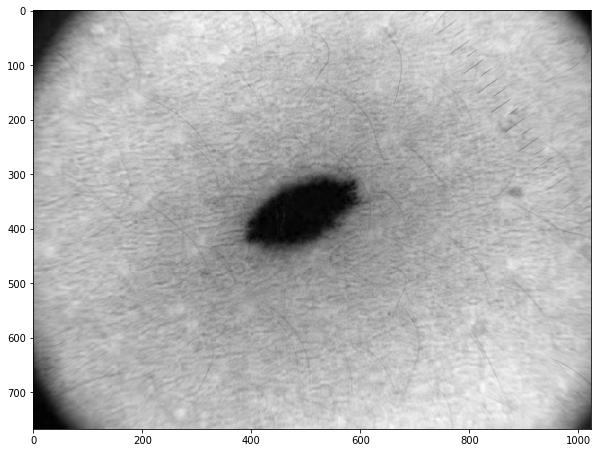

In [ ]:
#load image
url_pre  = 'https://raw.githubusercontent.com/sigvehaug/Introduction-to-Python-for-Medical-Researchers/master/Data/'
url_name = 'ISIC_0000098_downsampled.jpg'
imageRGB  = io.imread(url_pre+url_name)
image = image[:,:,2]
#plot image
plt.figure(figsize=(10,10))
plt.imshow(image,cmap = 'gray')
plt.show()

## 4.1 Filtering

A large set of filters are offered in scikit-image. Filtering is a local operation, where a value is calculated for each pixel and its surrounding region according to some function. For example a median filter of size 3, calculates for each pixel the median value of the 3x3 region around it.

Most filters take as input a specified region to consider for the calculation (e.g. 3x3 region). Those can be defined using the morphology module e.g.

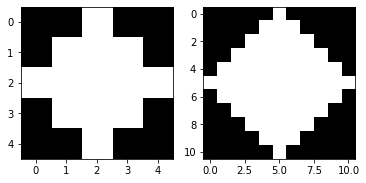

In [ ]:
disk = skm.disk(2)
diamond  = skm.diamond(5)
plt.subplot(1,2,1)
plt.imshow(disk,cmap = 'gray')
plt.subplot(1,2,2)
plt.imshow(diamond,cmap = 'gray')
plt.show()

In [ ]:
image_mean = skf.median(image,selem=skm.disk(3))

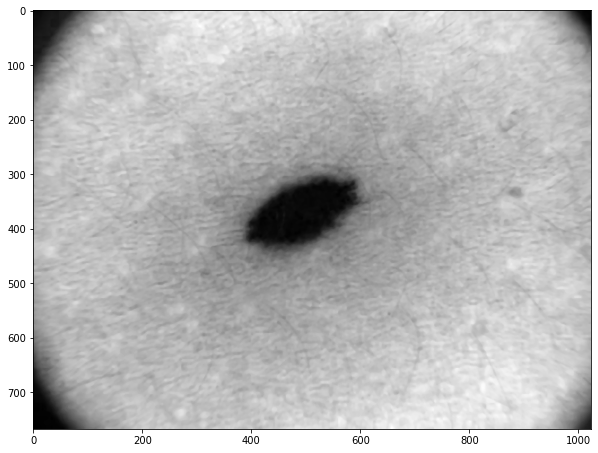

In [ ]:
plt.figure(figsize=(10,10))
plt.imshow(image_mean,cmap = 'gray')
plt.show()

Similar filters can be defined for a large range of operations: sum, min, max, mean etc.

More specific filters are also provide in skimage. For example finding the gradient of intensity in an image can be done with a Sobel filter. Here for horizontal, vertical and their sum:

In [ ]:
image_gradienth = skf.sobel_h(image)
image_gradientv = skf.sobel_v(image)
image_gradient = np.sqrt(image_gradientv**2+image_gradienth**2)

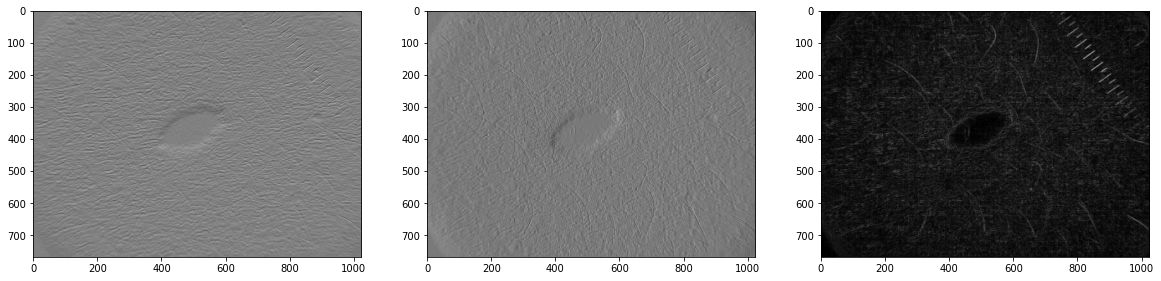

In [ ]:
plt.figure(figsize=(20,10))
plt.subplot(1,3,1)
plt.imshow(image_gradienth,cmap = 'gray')
plt.subplot(1,3,2)
plt.imshow(image_gradientv,cmap = 'gray')
plt.subplot(1,3,3)
plt.imshow(image_gradient,cmap = 'gray')
plt.show()

Finally, some functions can be used to filter the image, and one can pass function parameters to the filter. For example to filter with a Gaussian of large standard deviation $\sigma = 10$:

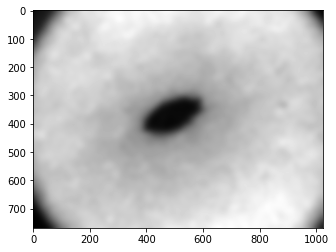

In [ ]:
image_gauss = skf.gaussian(image, sigma=10, preserve_range=True)

plt.imshow(image_gauss,cmap = 'gray')
plt.show()

## 4.2 Intensity re-scaling

A very common operation to do in an image processing pipeline, is to rescale the intensity of images. The reason can be diverse: for example, one might want to remove an offset added to each pixel by the camera, or one might want to homogenize multiple images with slightly varying exposures.

The simplest thing to do is to rescale from min to max in the range 0-1:

In [ ]:
np.ravel(image).shape # flatten image into 1D array

(786432,)

In [ ]:
image[:100,:]

array([[  9,   9,   9, ...,   5,   5,   6],
       [  9,   9,  10, ...,   5,   5,   6],
       [  9,  10,  10, ...,   5,   5,   6],
       ...,
       [ 26,  28,  30, ..., 130, 129, 128],
       [ 27,  29,  31, ..., 131, 129, 128],
       [ 28,  30,  32, ..., 132, 130, 128]], dtype=uint8)

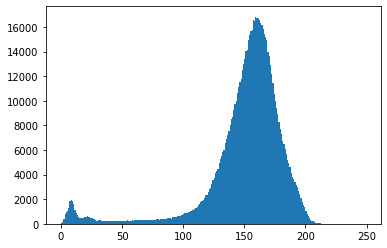

min val: 0
max val: 218


In [ ]:
plt.hist(np.ravel(image), bins = np.arange(0,250))
plt.show()
print("min val: "+ str(np.min(image)))
print("max val: "+ str(np.max(image)))

In [ ]:
image_minmax = (image-image.min())/(image.max()-image.min())
image_minmax[image_minmax>1] = 1

One problem that might emerge is that a few pixels might be affected by rare noise events that give them abnormal values. One way to remedy that is to use a small median filter in order to suppress those aberrant values:

In [ ]:
image_median = skf.median(image,selem=np.ones((2,2)))
print("min val: "+ str(np.min(image_median)))
print("max val: "+ str(np.max(image_median)))

image_median_rescale = (image_median-image_median.min())/(image_median.max()-image_median.min())
image_median_rescale[image_minmax>1] = 1

min val: 0
max val: 218


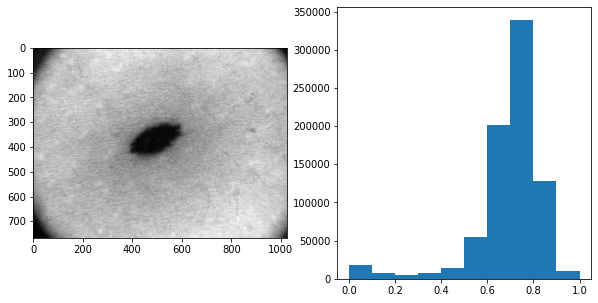

In [ ]:
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.imshow(image_median_rescale,cmap = 'gray')
plt.subplot(1,2,2)
plt.hist(np.ravel(image_median_rescale))#, bins = np.arange(0,250))
plt.show()

## 4.3 Thresholding

Another common operation is to try isolating regions of an image based on their intensity by using an intensity threshold: one can create a maks object where all values larger than a threshold are 1 and the other 0. It is usually better to use a smoothed version of the image (e.g. median or gaussian filtering) to avoid including noisy pixels in the maks.

Let us imagine that we want to isolate the nuclei in our current image. To do that we can try to use their bright contour. Based on the intensity histogram, let's try to pick a threshold manually:

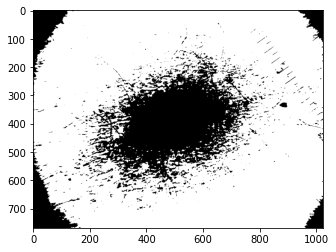

In [ ]:
threshold_manual = 140

#create a mask using a logical operation
image_threshold = image_median>threshold_manual

plt.imshow(image_threshold, cmap ='gray')
plt.show()

Instead of picking manually the threshold, one can use one of the many automatic methods available in skimage,

In [ ]:
image_otsu_threshold = skf.threshold_otsu(image_median)

In [ ]:
image_otsu_threshold

100

In [ ]:
image_otsu_threshold = skf.threshold_otsu(image_median)
print(image_otsu_threshold)
image_li_threshold = skf.threshold_li(image_median)
print(image_li_threshold)

100
73.00928299940944


Knowing that threshold value we can create a binary image setting all pixels higher than the threshold to 1.

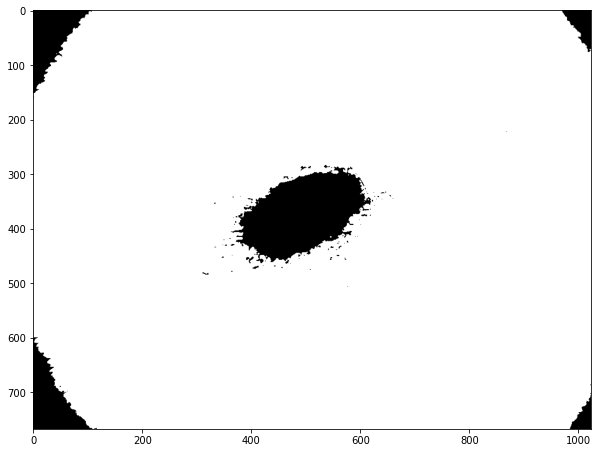

In [ ]:
image_otsu = image_median > image_otsu_threshold
plt.figure(figsize=(10,10))
plt.imshow(image_otsu, cmap = 'gray')
plt.show()

Since the illumination is uneven accross the image, all standard thresholding methods are going to fail in some region of the image. What we could try to do instead is using a local thresholding, by repeating a standard thresholding method in sub-regions of the image:

## Further Notes

Image processing is a large field. There is not space to cover all topics in this course, for example segmentation, classification etc. The purpose has been to get us used to think of images as numpy arrays and do basic operations on them.  